## Notes

tasks:
- node classification
- link classification

types of GNNs:
- convolutions (average over nodes in adj matrix)
- message passing (function over a message)
- graph attention

In [ ]:
!python -c "import torch; print(torch.__version__)"

1.10.0+cu111


In [ ]:
!python -c "import torch; print(torch.version.cuda)"

11.1


In [ ]:
%env TORCH=1.10.0
%env CUDA=cu111

env: TORCH=1.10.0
env: CUDA=cu111


In [ ]:
!echo ${TORCH}

1.10.0


In [ ]:
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-${TORCH}+${CUDA}.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-${TORCH}+${CUDA}.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-${TORCH}+${CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-${TORCH}+${CUDA}.html 

Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 7.9 MB 4.5 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 3.5 MB 1.7 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 2.3 MB 1.8 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 747 kB 3.9 MB/s 


In [ ]:
!pip install torch-geometric

     |████████████████████████████████| 325 kB 4.3 MB/s 
     |████████████████████████████████| 407 kB 37.9 MB/s 
     |████████████████████████████████| 45 kB 3.3 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.2-py3-none-any.whl size=535570 sha256=c5af9c1823ee5fdb5e7675fa3f9894cd8b504432ba06a7f87136a57dc5445e62
  Stored in directory: /root/.cache/pip/wheels/3f/08/13/2321517088bb2e95bfd0e45033bb9c923189e5b2078e0be4ef
Successfully built torch-geometric


In [ ]:
from torch_geometric.datasets import Reddit2
from torch_geometric.datasets import Planetoid

In [ ]:
dataset = Planetoid(root='/tmp/Planetoid', name='Cora')

Processing...
Done!


In [ ]:
# Helper function for visualization.
%matplotlib inline
import torch
import networkx as nx
import matplotlib.pyplot as plt


def visualize(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None:
            plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    else:
        nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                         node_color=color, cmap="Set2")
    plt.show()

Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:13: UserWarning: 'contains_isolated_nodes' is deprecated, use 'has_isolated_nodes' instead
  warnings.warn(out)
/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:13: UserWarning: 'contains_self_loops' is deprecated, use 'has_self_loops' instead
  warnings.warn(out)


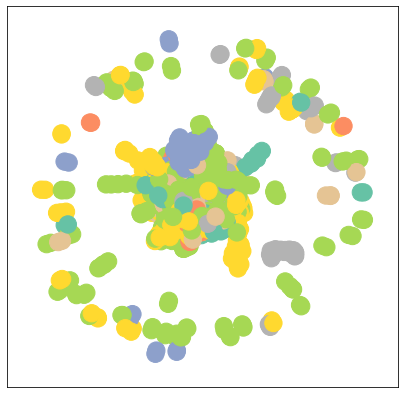

In [ ]:
 data = dataset[0]
 # Gather some statistics about the graph.
 print(f'Number of nodes: {data.num_nodes}')
 print(f'Number of edges: {data.num_edges}')
 print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
 print(f'Number of training nodes: {data.train_mask.sum()}')
 print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
 print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
 print(f'Contains self-loops: {data.contains_self_loops()}')
 print(f'Is undirected: {data.is_undirected()}')
 from torch_geometric.utils import to_networkx
 G = to_networkx(data, to_undirected=True)
#helper function, check colab notebook mentioned in endnotes
 visualize(G, color=data.y) 

In [ ]:
data.edge_index

tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])

In [ ]:
 import torch
 import torch.nn.functional as F
 from torch_geometric.nn import GCNConv, GATConv, GCN, GAT
 class Net(torch.nn.Module):
     def __init__(self):
         super(Net, self).__init__()
         self.conv1 = GAT(dataset.num_node_features, 16, num_layers=4)
         self.conv2 = GAT(16, dataset.num_classes, num_layers=4)
        #  self.conv1 = GATConv(dataset.num_node_features, 16)
        #  self.conv2 = GATConConvolutionv(16, dataset.num_classes)
     def forward(self, data):
         x, edge_index = data.x, data.edge_index
         x = self.conv1(x, edge_index)
         x = F.relu(x)
         x = self.conv2(x, edge_index)
         return F.log_softmax(x, dim=1) 

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
model.train()
epochs_range = [i for i in range(2,51)]
losses_1 = []
for epochs in epochs_range:
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
    model.eval()
    _, pred = model(data).max(dim=1)
    correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    acc = correct / int(data.test_mask.sum())
    losses_1.append(acc)
    #print('Accuracy: {:.4f}'.format(acc)) 

In [ ]:
len(epochs_range), len(losses_1)

(49, 49)

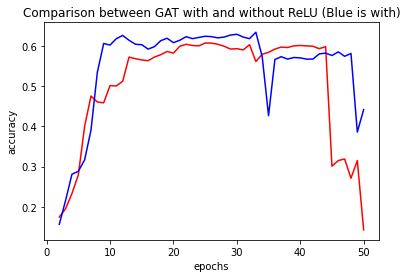

In [ ]:
plt.title("Comparison between GAT with and without ReLU (Blue is with)")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.plot(epochs_range, losses, color ="red")
plt.plot(epochs_range, losses_1, color ="blue")
plt.show()